In [44]:
print("Notebook is working")

Notebook is working


## Imports

In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, time, timezone, date as dt_date

## Stadium and game information

In [2]:
mlb_stadiums = {
    "Los Angeles Angels":       {"stadium":"Angel Stadium",           "latitude":33.8003,   "longitude":-117.8827,  "outfield_direction":44,"team_id":108},
    "Houston Astros":       {"stadium":"Minute Maid Park",        "latitude":29.7573,   "longitude":-95.3557,   "outfield_direction":343, "team_id":117},
    "Athletics":    {"stadium":"Sutter Health Park",      "latitude":38.58018,  "longitude":-121.51384, "outfield_direction":65,  "team_id":133},
    "Toronto Blue Jays":    {"stadium":"Rogers Centre",           "latitude":43.6414,   "longitude":-79.3894,   "outfield_direction":345, "team_id":141},
    "Atlanta Braves":       {"stadium":"Truist Park",             "latitude":33.8908,   "longitude":-84.4678,   "outfield_direction":145, "team_id":144},
    "Milwaukee Brewers":      {"stadium":"American Family Field",   "latitude":43.0286,   "longitude":-87.9711,   "outfield_direction":129, "team_id":158},
    "St. Louis Cardinals":    {"stadium":"Busch Stadium",           "latitude":38.62278,  "longitude":-90.19333,  "outfield_direction":62,  "team_id":138},
    "Chicago Cubs":         {"stadium":"Wrigley Field",           "latitude":41.9484,   "longitude":-87.6553,   "outfield_direction":37,  "team_id":112},
    "Arizona Diamondbacks": {"stadium":"Chase Field",             "latitude":33.4455,   "longitude":-112.0668,  "outfield_direction":0,   "team_id":109},
    "Los Angeles Dodgers":      {"stadium":"Dodger Stadium",          "latitude":34.0739,   "longitude":-118.2400,  "outfield_direction":26,  "team_id":119},
    "San Francisco Giants":       {"stadium":"Oracle Park",             "latitude":37.7786,   "longitude":-122.3893,  "outfield_direction":85,  "team_id":137},
    "Cleveland Guardians":    {"stadium":"Progressive Field",       "latitude":41.4962,   "longitude":-81.6853,   "outfield_direction":0,   "team_id":114},
    "Seattle Mariners":     {"stadium":"T-Mobile Park",           "latitude":47.5914,   "longitude":-122.3325,  "outfield_direction":49,  "team_id":136},
    "Miami Marlins":      {"stadium":"loanDepot Park",          "latitude":25.7781,   "longitude":-80.2195,   "outfield_direction":128, "team_id":146},
    "New York Mets":         {"stadium":"Citi Field",              "latitude":40.7571,   "longitude":-73.8458,   "outfield_direction":13,  "team_id":121},
    "Washington Nationals":    {"stadium":"Nationals Park",          "latitude":38.8730,   "longitude":-77.0074,   "outfield_direction":28,  "team_id":120},
    "Baltimore Orioles":      {"stadium":"Oriole Park at Camden Yards", "latitude":39.2839, "longitude":-76.6219, "outfield_direction":31,  "team_id":110},
    "San Diego Padres":       {"stadium":"Petco Park",              "latitude":32.7076,   "longitude":-117.1573,  "outfield_direction":0,   "team_id":135},
    "Philadelphia Phillies":     {"stadium":"Citizens Bank Park",      "latitude":39.9057,   "longitude":-75.1665,   "outfield_direction":9,   "team_id":143},
    "Pittsburgh Pirates":      {"stadium":"PNC Park",                "latitude":40.4469,   "longitude":-80.0057,   "outfield_direction":116, "team_id":134},
    "Texas Rangers":      {"stadium":"Globe Life Field",        "latitude":32.7473,   "longitude":-97.0831,   "outfield_direction":30,  "team_id":140},
    "Tampa Bay Rays":         {"stadium":"Tropicana Field",         "latitude":27.7682,   "longitude":-82.6534,   "outfield_direction":359, "team_id":139},
    "Boston Red Sox":      {"stadium":"Fenway Park",             "latitude":42.3467,   "longitude":-71.0972,   "outfield_direction":45,  "team_id":111},
    "Cincinnati Reds":         {"stadium":"Great American Ball Park","latitude":39.0974,   "longitude":-84.5060,   "outfield_direction":122, "team_id":113},
    "Colorado Rockies":      {"stadium":"Coors Field",             "latitude":39.7561,   "longitude":-104.9942,  "outfield_direction":4,   "team_id":115},
    "Kansas City Royals":       {"stadium":"Kauffman Stadium",        "latitude":39.0519,   "longitude":-94.4803,   "outfield_direction":46,  "team_id":118},
    "Detroit Tigers":       {"stadium":"Comerica Park",           "latitude":42.3390,   "longitude":-83.0485,   "outfield_direction":150, "team_id":116},
    "Minnesota Twins":        {"stadium":"Target Field",            "latitude":44.9817,   "longitude":-93.2773,   "outfield_direction":44,  "team_id":142},
    "Chicago White Sox":    {"stadium":"Guaranteed Rate Field",   "latitude":41.8309,   "longitude":-87.6339,   "outfield_direction":127, "team_id":145},
    "New York Yankees":      {"stadium":"Yankee Stadium",          "latitude":40.8296,   "longitude":-73.9262,   "outfield_direction":75,  "team_id":147}
}


In [3]:
def get_stadium_info(game, mlb_stadiums):
    home_team = game["teams"]["home"]["team"]["name"]
    return mlb_stadiums.get(home_team, None)


In [4]:
def get_home_stadium_info(team_name, stadium_dict, date):
    """Fetches today's game for the selected team and returns the home team name and stadium info."""
    team_id = stadium_dict[team_name]["team_id"]
    schedule_url = f"https://statsapi.mlb.com/api/v1/schedule?sportId=1&teamId={team_id}&date={date}"

    response = requests.get(schedule_url)
    data = response.json()
    games = data.get("dates", [])

    if not games:
        print(f"No game scheduled today for {team_name}.")
        return None, None

    game = games[0]["games"][0]
    home_team = game["teams"]["home"]["team"]["name"]

    if home_team not in stadium_dict:
        print(f"⚠️ No stadium data found for {home_team}. Wind effect analysis will be skipped.")
        return home_team, None

    print(f"{team_name} is playing at {home_team}'s stadium: {stadium_dict[home_team]['stadium']}")
    return home_team, stadium_dict[home_team]


In [16]:
team_name = "Baltimore Orioles"  # or any other team
date = dt_date.today().isoformat()
team_id = mlb_stadiums[team_name]["team_id"]

home_team, home_stadium = get_home_stadium_info(team_name, mlb_stadiums, date)

if home_stadium:
    latitude = home_stadium["latitude"]
    longitude = home_stadium["longitude"]
    stadium_name = home_stadium["stadium"]
    outfield_direction_deg = home_stadium["outfield_direction"]
else:
    latitude = longitude = stadium_name = outfield_direction_deg = None


Baltimore Orioles is playing at Baltimore Orioles's stadium: Oriole Park at Camden Yards


In [17]:
mlb_url = f"https://statsapi.mlb.com/api/v1/schedule?sportId=1&date={date}&teamId={team_id}"
mlb_response = requests.get(mlb_url)
mlb_data = mlb_response.json()

games = mlb_data.get("dates", [])


In [18]:
if games:
    game = games[0]["games"][0]  # First game today

    # Get home team name and stadium info
    team_name = game["teams"]["home"]["team"]["name"]
    stadium_data = mlb_stadiums.get(team_name)

    if stadium_data:
        stadium_name = stadium_data["stadium"]
        outfield_direction_deg = stadium_data["outfield_direction"]
        print(f"Stadium: {stadium_name}")
        print(f"Outfield direction: {outfield_direction_deg}°")
    else:
        print(f"⚠️ No stadium data found for {team_name}. Wind effect analysis will be skipped.")

    # Get and convert UTC start time to local hour
    utc_start = game["gameDate"]
    print("Raw UTC start time:", utc_start)
    utc_dt = datetime.strptime(utc_start, "%Y-%m-%dT%H:%M:%SZ")
    local_hour = (utc_dt.hour - 4) % 24  # Adjust if needed
    game_hour = local_hour
    print("Local game hour:", game_hour)

else:
    print("No game scheduled today.")
    game_hour = None


Stadium: Oriole Park at Camden Yards
Outfield direction: 31°
Raw UTC start time: 2025-07-29T16:35:00Z
Local game hour: 12


In [19]:
# Convert UTC time to your local time zone
dt_utc = datetime.fromisoformat(utc_start.replace("Z", "+00:00"))
dt_local = dt_utc.astimezone(tz=None)  # Auto-detects your system's local time
game_hour = dt_local.hour

print("Local start time:", dt_local)
print("Start hour only (for filtering):", game_hour)


Local start time: 2025-07-29 12:35:00-04:00
Start hour only (for filtering): 12


In [20]:
#WEATHER API CALL
if latitude is not None and longitude is not None:
    weather_url = "https://api.open-meteo.com/v1/forecast"
    weather_params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": date,
        "end_date": date,
        "hourly": "winddirection_10m,windspeed_10m",
        "timezone": "America/New_York"
    }

    weather_resp = requests.get(weather_url, params=weather_params)
    weather_data = weather_resp.json()
else:
    print("Cannot fetch weather data — location information is missing.")


In [21]:
def filter_for_game_time(data, start_hour, end_hour):
    hourly = data["hourly"]
    times = hourly["time"]
    directions = hourly["winddirection_10m"]
    speeds_kmh = hourly["windspeed_10m"]

    filtered = []

    for i, t_str in enumerate(times):
        dt = datetime.strptime(t_str, "%Y-%m-%dT%H:%M")
        if start_hour <= dt.hour <= end_hour:
            filtered.append({
                "time": t_str,
                "direction_deg": directions[i],
                "speed_kmh": speeds_kmh[i],
                "speed_mph": round(speeds_kmh[i] * 0.621371, 2)
            })

    return filtered


In [22]:
def degrees_to_cardinal(degrees):
    dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    ix = round(degrees / 45) % 8
    return dirs[ix]

In [23]:
if game_hour is not None:
    filtered_wind = filter_for_game_time(weather_data, start_hour=game_hour, end_hour=game_hour+3)

    for entry in filtered_wind:
        cardinal = degrees_to_cardinal(entry["direction_deg"])

        if outfield_direction_deg is not None:
            wind_blowing_toward = (entry["direction_deg"] + 180) % 360
            angle_diff = abs(wind_blowing_toward - outfield_direction_deg)
            angle_diff = min(angle_diff, 360 - angle_diff)

            if angle_diff <= 45:
                effect = "Blowing out"
            elif angle_diff >= 135:
                effect = "Blowing in"
            else:
                effect = "Cross-wind"

            effect_text = f", Effect: {effect}"
        else:
            effect_text = ""

        print(f"Time: {entry['time']}, Direction: {entry['direction_deg']}° ({cardinal}), "
              f"Speed: {entry['speed_kmh']} km/h ({entry['speed_mph']} mph){effect_text}")

    # Store the wind direction
    if filtered_wind:
        wind_direction_deg = (filtered_wind[0]["direction_deg"] + 180) % 360  # now it's "to" direction
        print(f"\n✅ Wind blowing toward: {wind_direction_deg}° (used for visualization)")
    else:
        wind_direction_deg = None

else:
    print("There is no game today.")


Time: 2025-07-29T12:00, Direction: 102° (E), Speed: 5.2 km/h (3.23 mph), Effect: Cross-wind
Time: 2025-07-29T13:00, Direction: 169° (S), Speed: 5.9 km/h (3.67 mph), Effect: Blowing out
Time: 2025-07-29T14:00, Direction: 174° (S), Speed: 6.5 km/h (4.04 mph), Effect: Blowing out
Time: 2025-07-29T15:00, Direction: 119° (SE), Speed: 8.2 km/h (5.1 mph), Effect: Cross-wind

✅ Wind blowing toward: 282° (used for visualization)


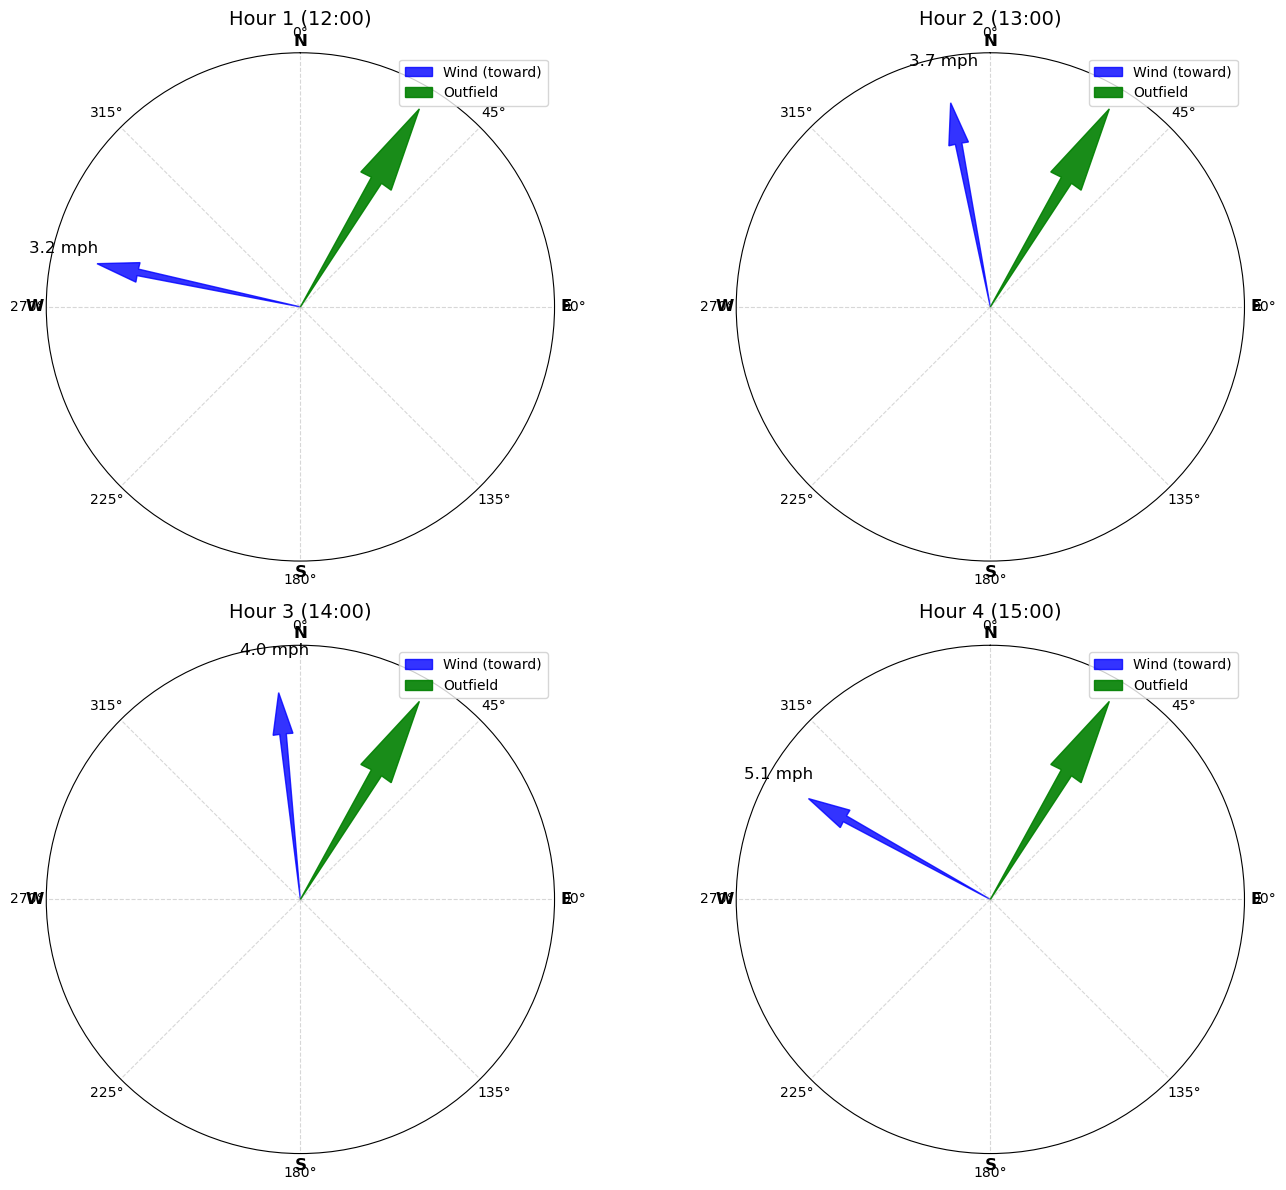

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

# Number of plots = number of wind entries
num_hours = len(filtered_wind)
cols = 2
rows = math.ceil(num_hours / cols)

fig, axes = plt.subplots(rows, cols, subplot_kw={'projection': 'polar'}, figsize=(7 * cols, 6 * rows))
axes = axes.flatten()

for i, entry in enumerate(filtered_wind):
    ax = axes[i]
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    # Wind direction (blowing toward)
    wind_toward_deg = (entry["direction_deg"] + 180) % 360
    theta_wind = np.deg2rad(wind_toward_deg)
    speed_mph = entry["speed_mph"]

    # Plot wind arrow (shorter & thinner)
    ax.arrow(theta_wind, 0, 0, 0.9,
             width=0.04, color='blue', alpha=0.8,
             label='Wind (toward)', length_includes_head=True)

    # Show wind speed text along wind arrow
    ax.text(theta_wind, 1.05, f"{speed_mph:.1f} mph",
        fontsize=12, color='black', ha='center', va='bottom')

    # Plot outfield direction arrow
    if outfield_direction_deg is not None:
        theta_outfield = np.deg2rad(outfield_direction_deg)
        ax.arrow(theta_outfield, 0, 0, 1,
                 width=0.08, color='green', alpha=0.9,
                 label='Outfield', length_includes_head=True, zorder=10)

    # Customize grid and labels
    ax.set_rmax(1.1)
    ax.set_rticks([])
    ax.set_rlabel_position(0)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Cardinal direction labels
    for angle, label in zip([0, 90, 180, 270], ['N', 'E', 'S', 'W']):
        ax.text(np.deg2rad(angle), 1.15, label,
                fontsize=12, fontweight='bold',
                ha='center', va='center')

    # Title and legend
    time_label = entry["time"][-5:]
    ax.set_title(f"Hour {i+1} ({time_label})", fontsize=14, pad=20)
    ax.legend(loc='upper right')

# Hide unused plots
for j in range(len(filtered_wind), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
